# Lecture 2 - Introduction to Transformers Laboratory - Part 2

## Overview of this Notebook

This is an addendum of the previous part, where we'll see how to extract hidden states and attention patterns from these models, which will be useful in some of the next lectures to try to understand the behaviour of these models.

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch

In [ ]:
model_name = 'dbmdz/bert-base-italian-cased'

model = AutoModel.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

Let's see for a moment how the model is made.

In [ ]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31102, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

## Bert Structure

This specific instance of this Bert follows the following structure:
- It has an Embeddings Layer which has a shape $(31102 \times 768)$. This is $vocab\_size \times hidden\_size$. Basically this functions as a lookup table: for each token possible in the vocabulary, we get a pre-trained dense representation of size 768. To this representation, a PostionalEmbeddings gets added, which has shape $(512 \times 768)$. Here, the lookup table has the token's position as keys. Basically these are representation learned by the model for each position, and they get **added** to the token's representation. Then, as it happens at the end of each layer, all representation get normalized so that the final vector that represents each token has mean 0 and std 1.
- Then the model has 12 layers consisting of a Self Attention Layer, and a Multi-Layer Perceptron (MLP). The key insights are these:
  - The Self-Attention "moves" information from one tokens to the other. Basically each token uses other's token information to build its own representation. What this practically does is moving information from one token's representation to the others, creating contextualized embeddings.
  - The MLP is a little network that gets as input the matrix of size $n\_tokens \times hidden\_size$, then it outputs a matrix of $n\_tokens \times 4(hidden\_size)$. Here we have the only non-linear part of a Transformer, the activation function, which in this case is a GELU. Then the MLP finally outputs again a matrix of size $n\_tokens \times hidden\_size$.
  Again here we find a Layer Norm.
At the end of this stack any kind of head can be placed depending on the needs. Here we just have a Hyperbolic Tangent activation to normalize the final hidden states from -1 to 1.

Now let's see how to extract some of these representations

## Bert Representations
We'll see how to extract the hidden representation that Bert builds during the inference process. These can be useful as a base for a classifier, a regressor, etc. We'll see how to plot these representations and see how they are distributed in the space.

In [ ]:
frase_input = "Il cane gioca con il gatto ma non con il topo. Il gatto ignora il cane e vuole mangiare il topo, quest'ultimo invece si nasconde tra le gambe del cane."

tokens = tokenizer.tokenize(frase_input, add_special_tokens=True)
input_ids = tokenizer.encode(frase_input, add_special_tokens=True)

In [ ]:
print("Tokens:", tokens)
print("Token Ids:", input_ids)

Tokens: ['[CLS]', 'Il', 'cane', 'gioca', 'con', 'il', 'gatto', 'ma', 'non', 'con', 'il', 'topo', '.', 'Il', 'gatto', 'ignora', 'il', 'cane', 'e', 'vuole', 'mangiare', 'il', 'topo', ',', 'quest', "'", 'ultimo', 'invece', 'si', 'nasconde', 'tra', 'le', 'gambe', 'del', 'cane', '.', '[SEP]']
Token Ids: [102, 329, 5988, 1838, 153, 162, 11718, 220, 212, 153, 162, 13813, 697, 329, 11718, 16497, 162, 5988, 126, 1794, 4852, 162, 13813, 1307, 2039, 1553, 4876, 1718, 223, 15062, 293, 199, 8809, 136, 5988, 697, 103]


In [ ]:
input_ids = torch.tensor([input_ids])

with torch.no_grad():
  outputs = model(input_ids)

all_hidden_states = outputs["hidden_states"]
attention_heads = outputs["attentions"]

In [ ]:
all_hidden_states[0].shape

torch.Size([1, 37, 768])

For each layer, we obtain the hidden states which have shape $(batch\_size \times n\_tokens \times hidden\_size)$

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

We can extract the last hidden states

In [ ]:
last_hidden = all_hidden_states[-1].squeeze()
last_hidden.shape

torch.Size([37, 768])

And using a Dimension-reduction technique such as PCA or T-SNE we can plot each token and see how they arrange in the space:

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5, max_iter=1000)
tokens_2d = tsne.fit_transform(last_hidden)

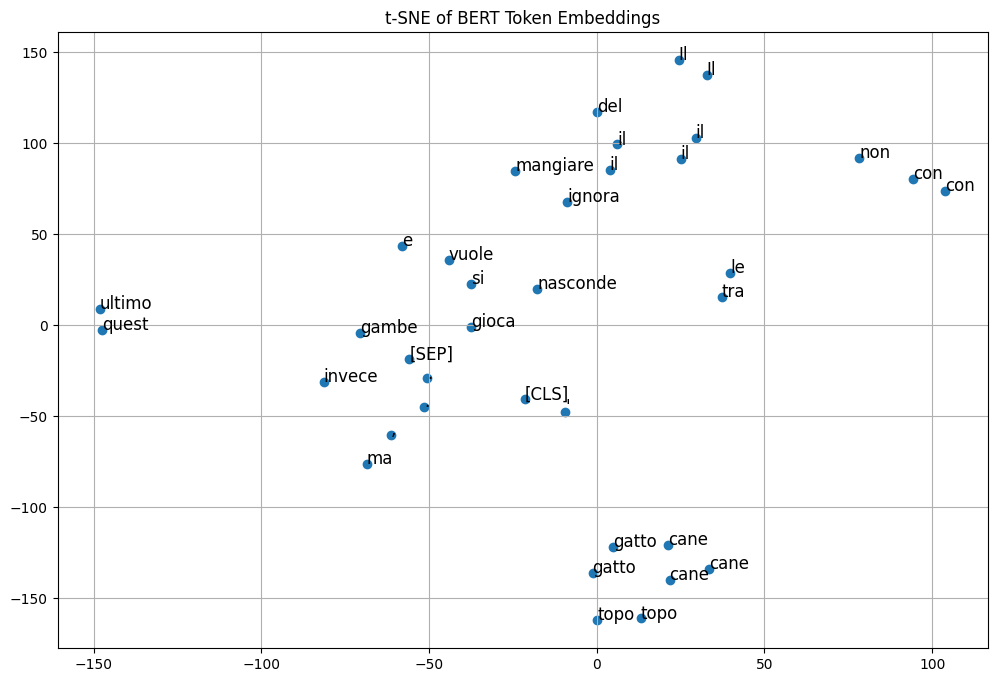

In [ ]:
plt.figure(figsize=(12, 8))
x, y = tokens_2d[:, 0], tokens_2d[:, 1]
plt.scatter(x, y)

for i, token in enumerate(tokens):
    plt.annotate(token, (x[i], y[i]), fontsize=12)

plt.title("t-SNE of BERT Token Embeddings")
plt.grid(True)
plt.show()

## Attention Matrices

We'll see how to extract and plot Attention Matrices from the Bert's inferences. These can be used to understand how the token's representations are built, which are useful insights into the model behaviour.

In [ ]:
frase_input = "Il cane gioca con il gatto ma non con il topo."

tokens = tokenizer.tokenize(frase_input, add_special_tokens=True)
input_ids = tokenizer.encode(frase_input, add_special_tokens=True)

In [ ]:
input_ids = torch.tensor([input_ids])
print(input_ids.shape)

with torch.no_grad():
  outputs = model(input_ids)

all_hidden_states = outputs["hidden_states"]
attention_heads = outputs["attentions"]

torch.Size([1, 14])


In [ ]:
len(attention_heads) # Layers

12

In [ ]:
attention_heads[0].shape

torch.Size([1, 12, 14, 14])

What we have here is a matrix of shape $(batch\_size \times n\_heads \times n\_tokens \times n\_tokens )$

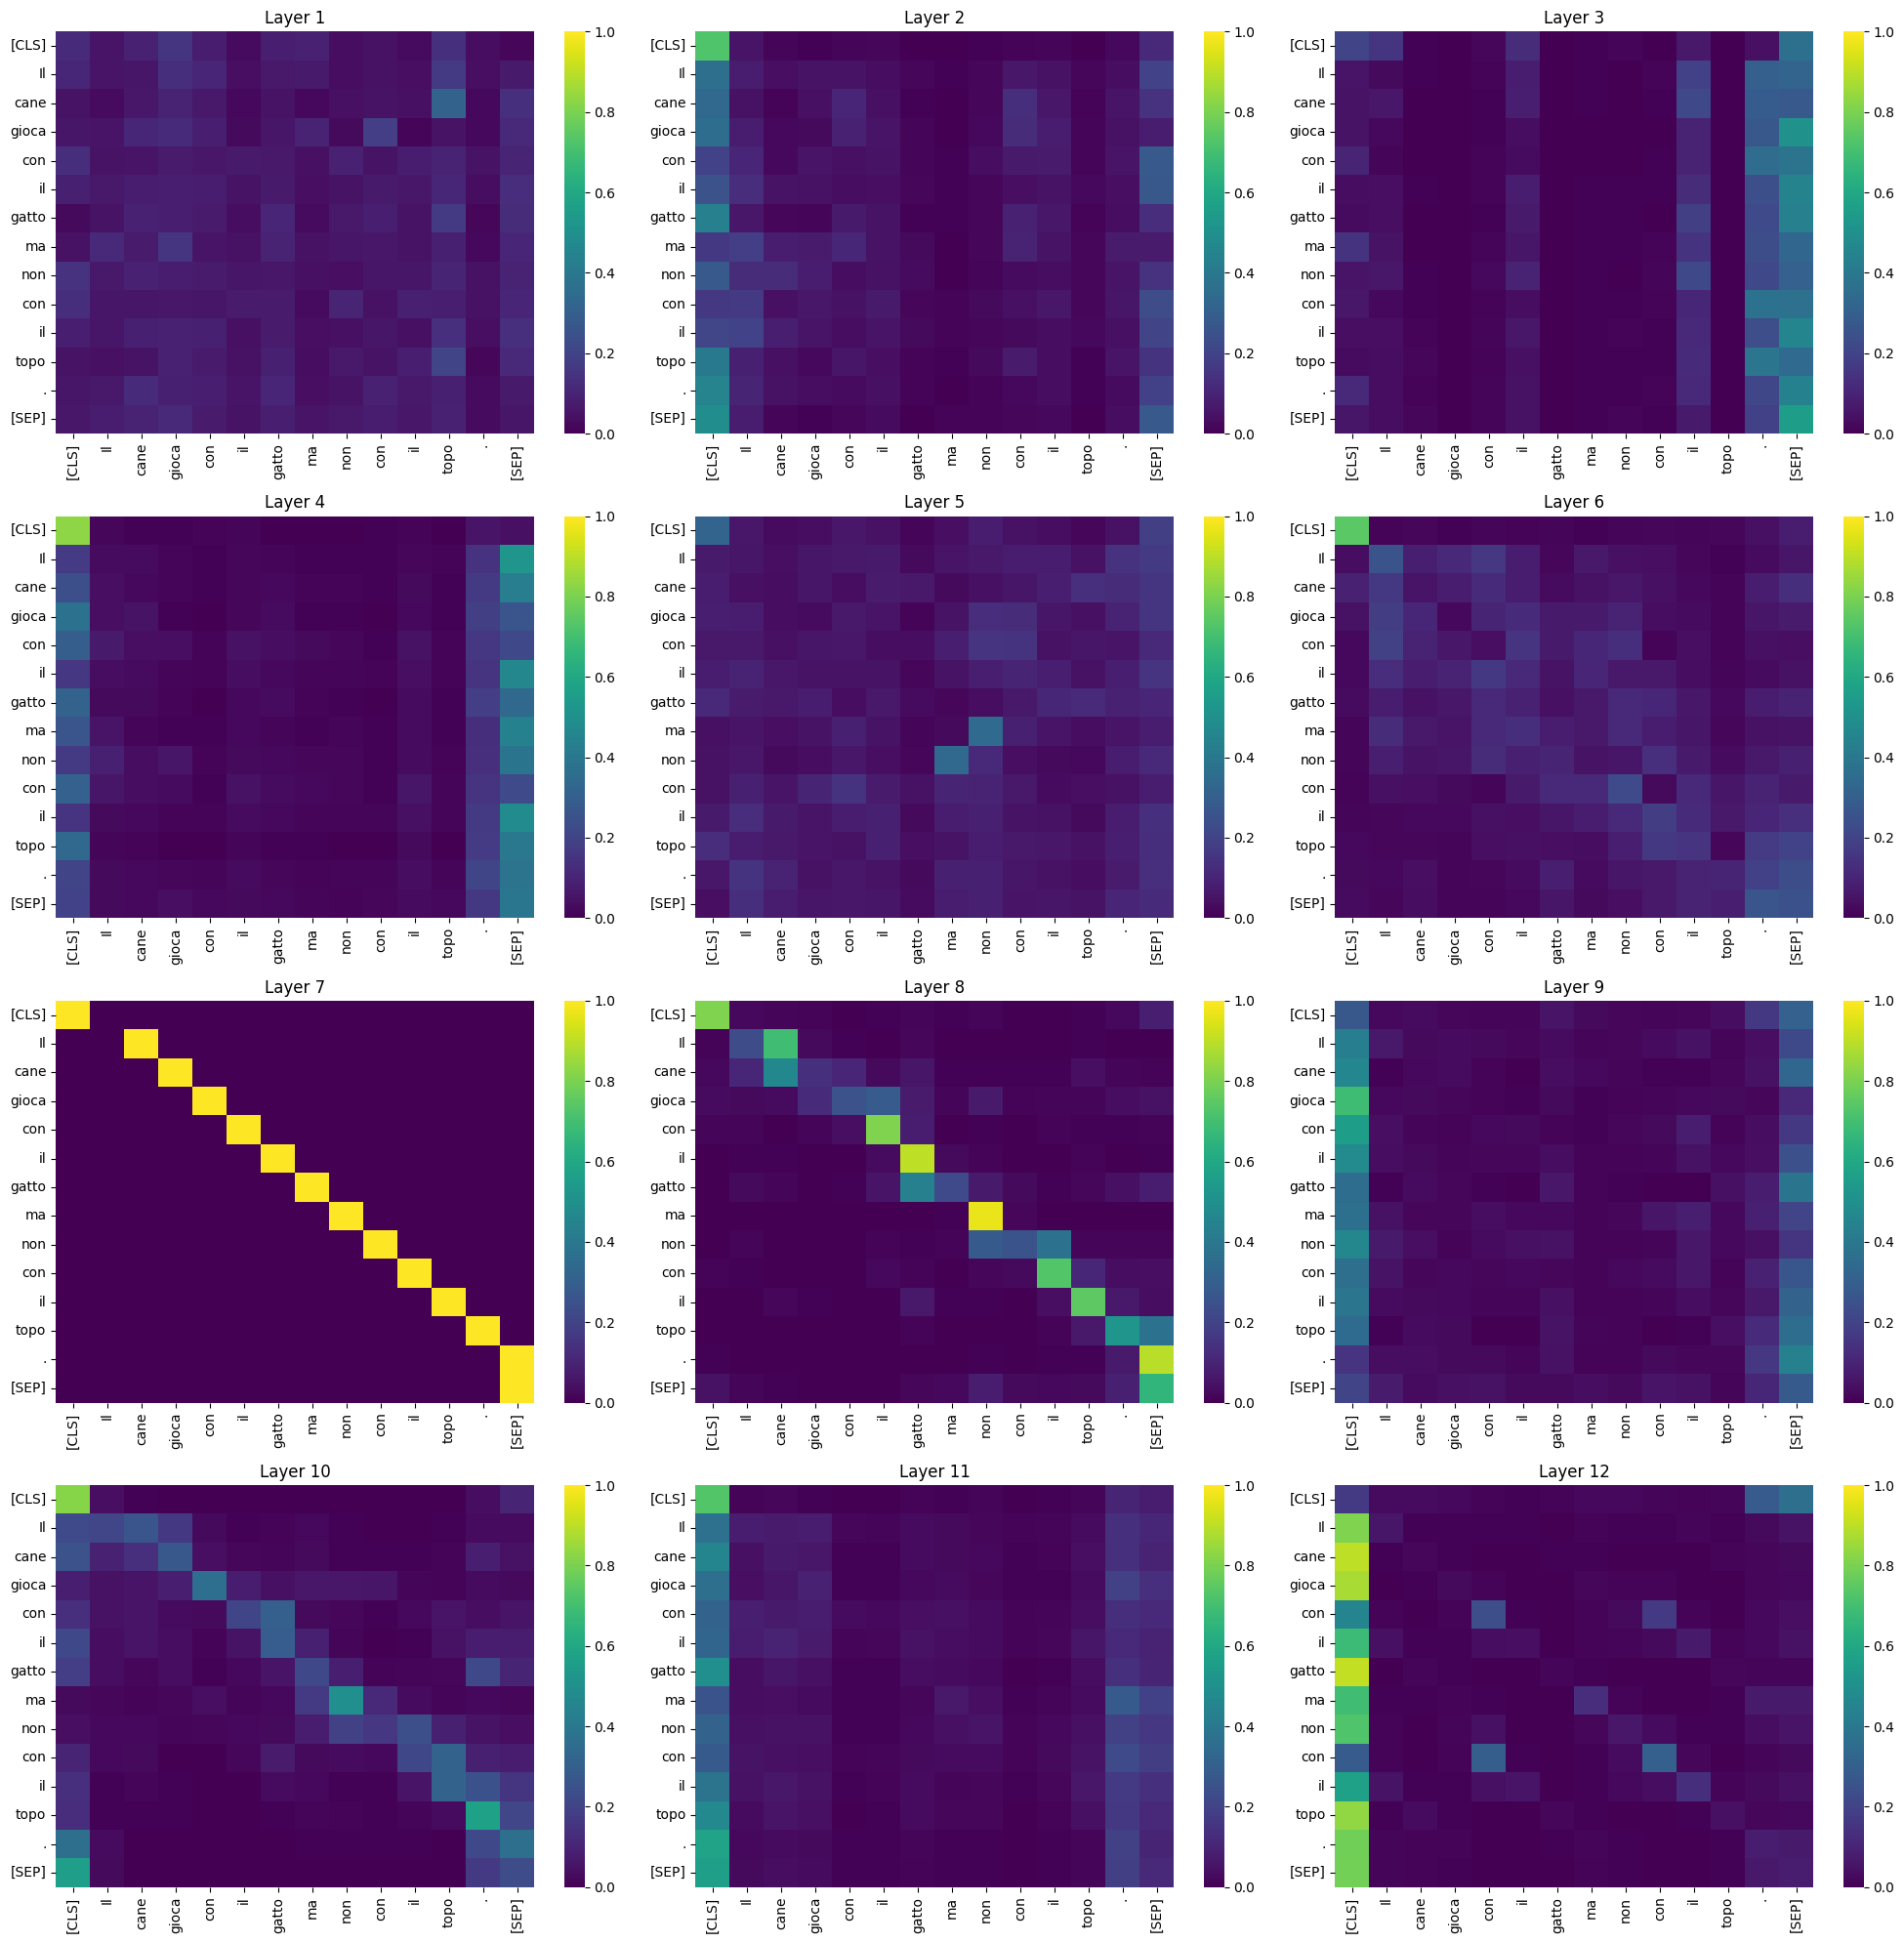

In [ ]:
head = 0 # We decide to look only at the first head of each layer

fig = plt.figure(figsize=(20, 20))

for idx, matrix in enumerate(attention_heads):

  matrix = matrix.squeeze() # We remove the batch_size, since it's one.

  head_matrix = matrix[head] # We look only at one head, obtaining a matrix of n_tokens x n_tokens

  ax = fig.add_subplot(4, 3, idx+1)

  # plot the matrix heatmap
  sns.heatmap(head_matrix, cmap='viridis', yticklabels=tokens, xticklabels=tokens, vmin=0, vmax=1)

  ax.set_title('{} {}'.format("Layer", idx+1))

plt.tight_layout()

plt.show()

Another way to account for all heads is the following

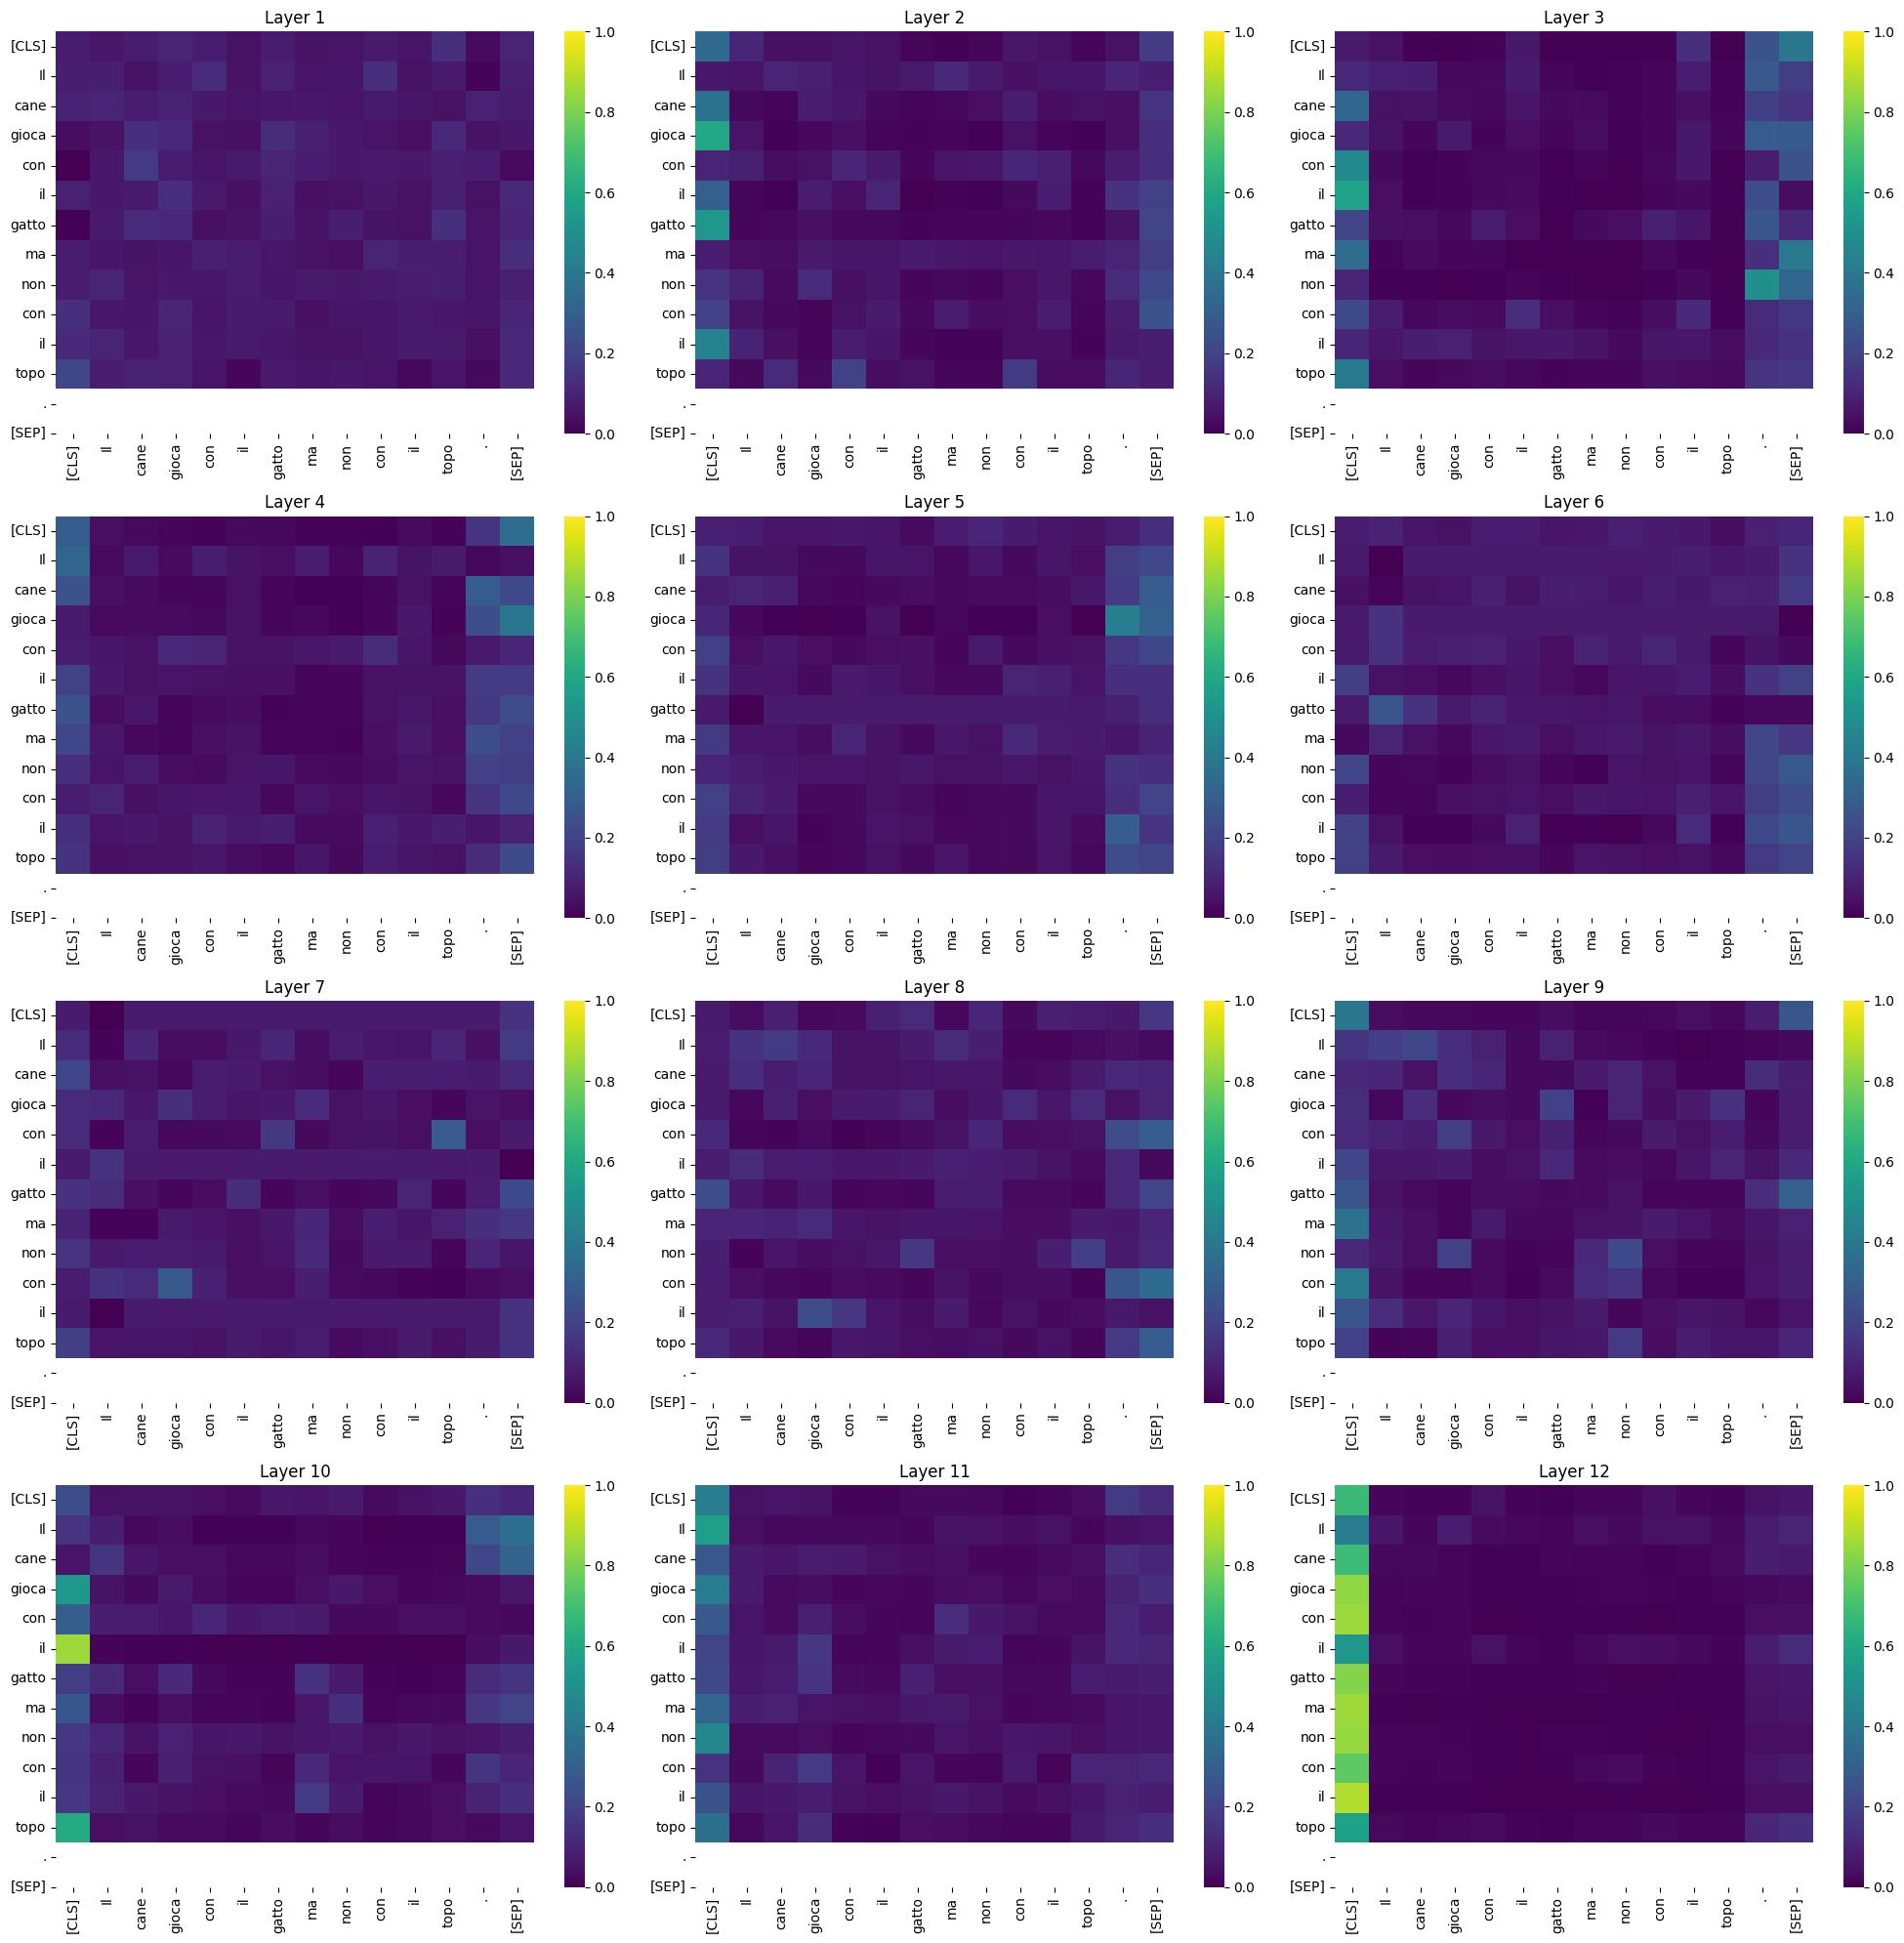

In [ ]:
fig = plt.figure(figsize=(20, 20))

for idx, matrix in enumerate(attention_heads):

  matrix = matrix.squeeze() # We remove the batch_size, since it's one.

  head_matrix = head_matrix = torch.mean(matrix, 1)

  ax = fig.add_subplot(4, 3, idx+1)

  # plot the matrix heatmap
  sns.heatmap(head_matrix, cmap='viridis', yticklabels=tokens, xticklabels=tokens, vmin=0, vmax=1)

  ax.set_title('{} {}'.format("Layer", idx+1))

plt.tight_layout()

plt.show()

We can also look at a single layer, but trough all the heads

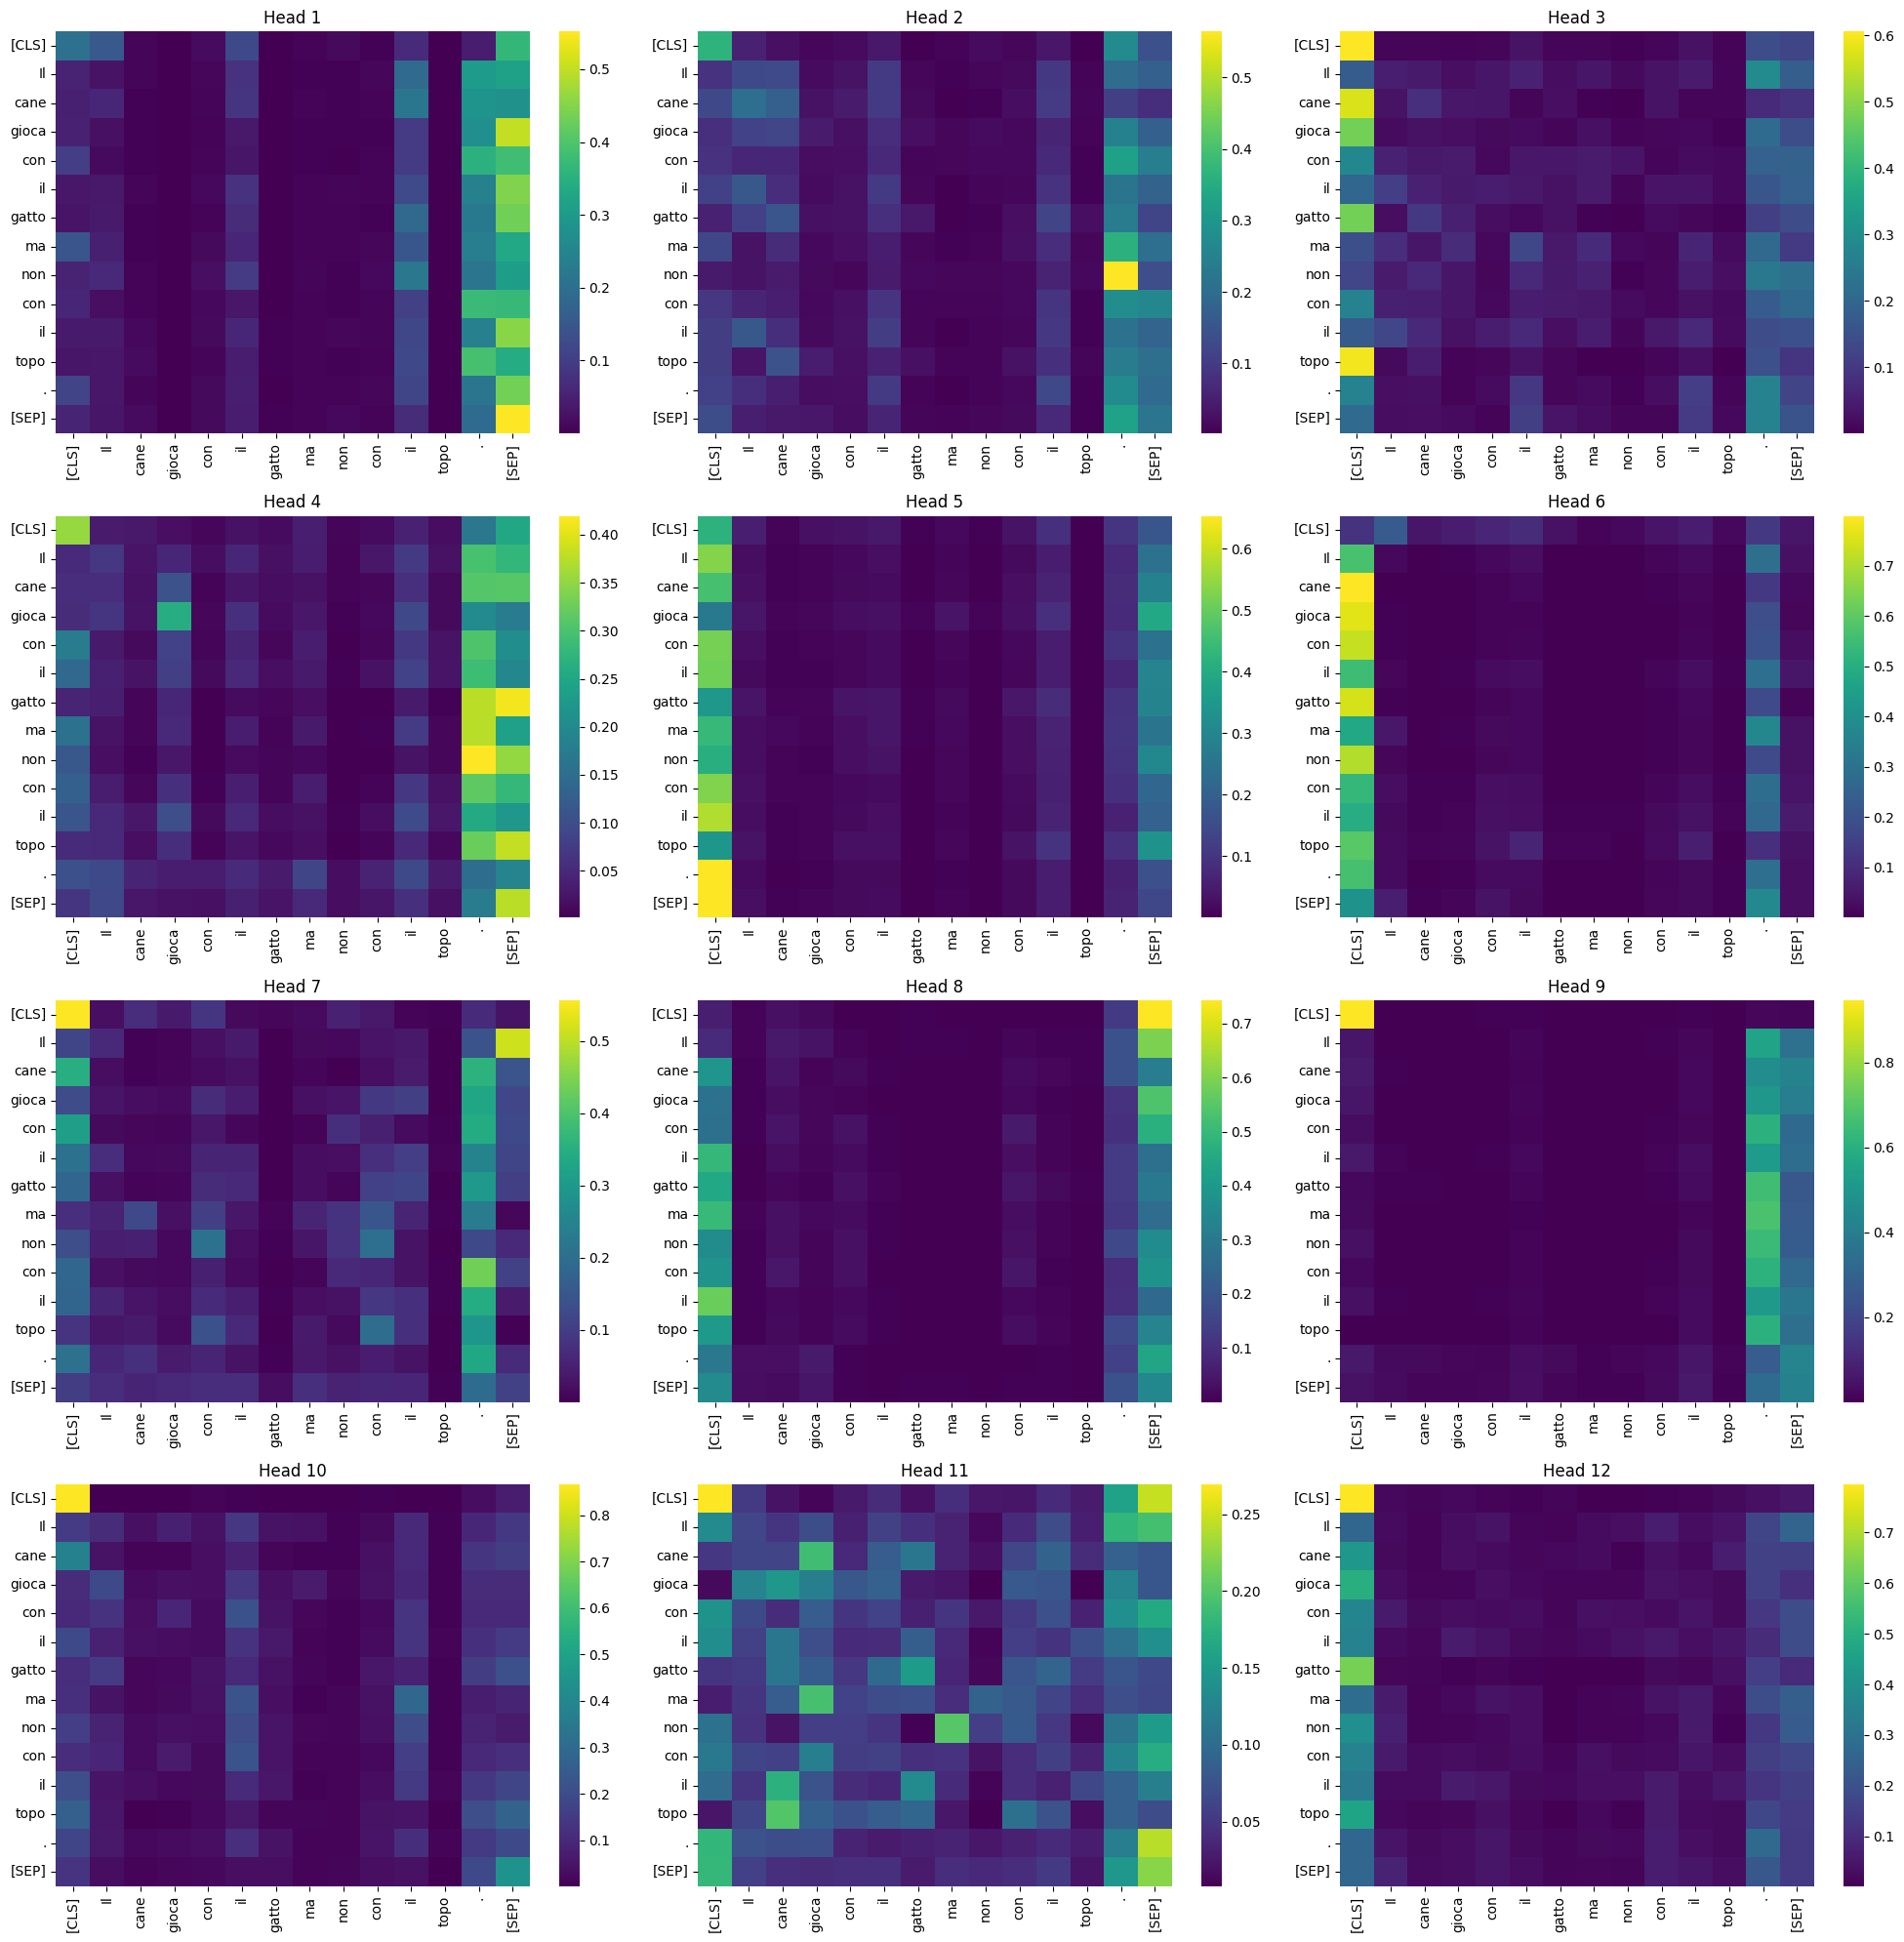

In [ ]:
layer = 2

fig = plt.figure(figsize=(20, 20))

attention_layer = attention_heads[layer].squeeze()

for idx, matrix in enumerate(attention_layer): # we iterate trough the heads
  ax = fig.add_subplot(4, 3, idx+1)

  sns.heatmap(matrix, cmap='viridis', yticklabels=tokens, xticklabels=tokens)

  ax.set_title('{} {}'.format("Head", idx+1))

plt.tight_layout()
plt.show()